<a href="https://colab.research.google.com/github/jixaw31/Computer-Vision-projects/blob/main/weather_temp_forecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import pandas as pd, tensorflow as tf, os, numpy as np, matplotlib.pyplot as plt
from zipfile import ZipFile

In [7]:


uri = "https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip"
zip_path = tf.keras.utils.get_file(origin=uri, fname="jena_climate_2009_2016.csv.zip")
zip_file = ZipFile(zip_path)
zip_file.extractall()
# csv_path = "C:\\Users\\jix\\Desktop\\PROJECTS\\time-series\\jena_climate_2009_2016.csv"

df = pd.read_csv('/content/jena_climate_2009_2016.csv')


In [8]:
df_hourly = df[::6]
len(df_hourly)
df_hourly.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
6,01.01.2009 01:10:00,996.50,-7.62,265.81,-8.30,94.8,3.44,3.26,0.18,2.04,3.27,1305.68,0.18,0.63,166.5
12,01.01.2009 02:10:00,996.63,-8.85,264.57,-9.70,93.5,3.12,2.92,0.20,1.82,2.93,1312.11,0.16,0.50,158.3
18,01.01.2009 03:10:00,996.87,-8.84,264.56,-9.69,93.5,3.13,2.92,0.20,1.83,2.93,1312.37,0.07,0.25,129.3
24,01.01.2009 04:10:00,997.05,-9.23,264.15,-10.25,92.2,3.03,2.79,0.24,1.74,2.80,1314.62,0.10,0.38,203.9


In [9]:
len(df_hourly)

70092

In [10]:
df_hourly.index = pd.to_datetime(df_hourly['Date Time'], format=r'%d.%m.%Y %H:%M:%S')
# df_hourly.index = np.arange(0, len(df_hourly))



In [11]:

del df_hourly['Date Time']


In [12]:
df_hourly.head()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
Date Time,,,,,,,,,,,,,,
2009-01-01 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
2009-01-01 01:10:00,996.50,-7.62,265.81,-8.30,94.8,3.44,3.26,0.18,2.04,3.27,1305.68,0.18,0.63,166.5
2009-01-01 02:10:00,996.63,-8.85,264.57,-9.70,93.5,3.12,2.92,0.20,1.82,2.93,1312.11,0.16,0.50,158.3
2009-01-01 03:10:00,996.87,-8.84,264.56,-9.69,93.5,3.13,2.92,0.20,1.83,2.93,1312.37,0.07,0.25,129.3
2009-01-01 04:10:00,997.05,-9.23,264.15,-10.25,92.2,3.03,2.79,0.24,1.74,2.80,1314.62,0.10,0.38,203.9


<Axes: xlabel='Date Time'>

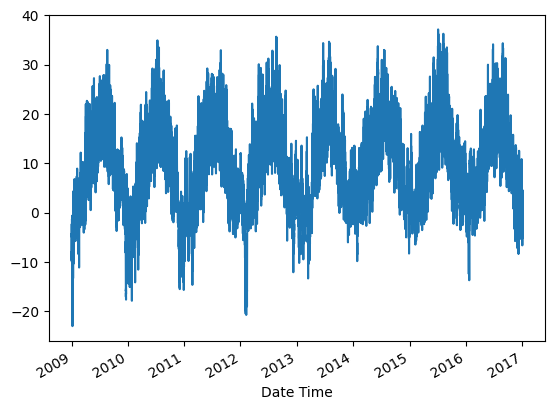

In [13]:
tempC = df_hourly['T (degC)']
tempC.plot()

In [14]:
def df_to_X_y(df_hourly, window_size=5):
    df_hourly_np = df_hourly.to_numpy()
    X = []
    y = []
    for i in range(len(df_hourly_np) - window_size):
        row = [[a] for a in df_hourly_np[i:i+5]]
        X.append(row)
        label = df_hourly_np[i+5]
        y.append(label)
    return np.array(X), np.array(y)

In [15]:
WINDOW_SIZE = 5
X, y = df_to_X_y(tempC, WINDOW_SIZE)
X.shape, y.shape

((70087, 5, 1), (70087,))

In [16]:
X_train, y_train = X[:6000], y[:6000]
X_val, y_val = X[6000:6500], y[6000:6500]
X_test, y_test = X[6500:], y[6500:]


In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, LSTM, Dense, LeakyReLU
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

# defininig model
# tf.config.threading.set_intra_op_parallelism_threads(2)
# tf.config.threading.set_inter_op_parallelism_threads(2)
# with tf.device('/CPU:0'):
model_1 = Sequential()
model_1.add(InputLayer((5, 1)))
model_1.add(LSTM(64))
model_1.add(Dense(8))
model_1.add(LeakyReLU(0.2))
model_1.add(Dense(1, 'linear'))

# dsiplay architecture
model_1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                16896     
                                                                 
 dense (Dense)               (None, 8)                 520       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 8)                 0         
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 17425 (68.07 KB)
Trainable params: 17425 (68.07 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [20]:
checkpoint = ModelCheckpoint('model_1.keras', save_best_only=True)

# model_1.compile(optimizer='adam',
#               loss='mse',
#               metrics=[RootMeanSquaredError()])

model_1.compile(optimizer=Adam(learning_rate=0.0001),
              loss=MeanSquaredError(),
              metrics=[RootMeanSquaredError()])

In [21]:
model_1.fit(X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=10, callbacks=checkpoint)

Epoch 1/10
188/188 [==============================] - 5s 7ms/step - loss: 171.4953 - root_mean_squared_error: 13.0956 - val_loss: 180.1440 - val_root_mean_squared_error: 13.4218
Epoch 2/10
188/188 [==============================] - 1s 4ms/step - loss: 118.1621 - root_mean_squared_error: 10.8702 - val_loss: 77.9731 - val_root_mean_squared_error: 8.8302
Epoch 3/10
188/188 [==============================] - 1s 5ms/step - loss: 51.3418 - root_mean_squared_error: 7.1653 - val_loss: 22.6130 - val_root_mean_squared_error: 4.7553
Epoch 4/10
188/188 [==============================] - 1s 4ms/step - loss: 23.4310 - root_mean_squared_error: 4.8406 - val_loss: 9.6163 - val_root_mean_squared_error: 3.1010
Epoch 5/10
188/188 [==============================] - 1s 4ms/step - loss: 14.0487 - root_mean_squared_error: 3.7482 - val_loss: 5.7041 - val_root_mean_squared_error: 2.3883
Epoch 6/10
188/188 [==============================] - 1s 4ms/step - loss: 9.8085 - root_mean_squared_error: 3.1319 - val_loss:

In [32]:
import os

model_1.save('/content/time series model')

In [25]:
print(os.getcwd())

/content


In [23]:
from tensorflow.keras.models import load_model

model_1_loaded = load_model('/content/model_1.keras')
model_1_loaded.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                16896     
                                                                 
 dense (Dense)               (None, 8)                 520       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 8)                 0         
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 17425 (68.07 KB)
Trainable params: 17425 (68.07 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [27]:
test_pred = model_1.predict(X_test)

test_pred

1988/1988 [==============================] - 7s 3ms/step


array([[13.247423 ],
       [13.301078 ],
       [13.456234 ],
       ...,
       [-1.651872 ],
       [-2.14754  ],
       [-2.7136393]], dtype=float32)

In [31]:

test_results = pd.DataFrame(data={'Train predictions': test_pred.flatten(),
                                  'actual y test': y_test})

test_results

,Train predictions,actual y test
0,13.247423,13.26
1,13.301078,13.39
2,13.456234,13.41
3,13.455159,13.27
4,13.268222,13.08
...,...,...
63582,-0.829043,-1.40
63583,-1.295386,-2.15
63584,-1.651872,-2.61
63585,-2.147540,-3.22


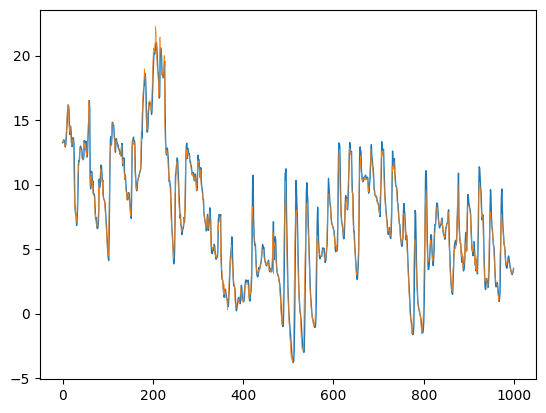

In [45]:
import matplotlib.pyplot as plt

test_results
plt.plot(test_results['Train predictions'][:1000],linewidth=1)
plt.plot(test_results['actual y test'][:1000], linewidth=0.5)
